#ENV

In [1]:
import numpy as np
from scipy.stats import poisson

# Constants
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = 2
RENT_REWARD = 10
DISCOUNT = 0.2
EXTRA_PARK_COST = 4  # Extra cost for more than 10 cars at a location

# Poisson lambda values
LAMBDA_REQUEST_1 = 3
LAMBDA_REQUEST_2 = 4
LAMBDA_RETURN_1 = 3
LAMBDA_RETURN_2 = 2

# Action Space: -5 (move from loc2 to loc1) to 5 (move from loc1 to loc2)
ACTIONS = np.arange(-MAX_MOVE, MAX_MOVE + 1)

In [2]:
def step(state, action):
    # Apply action: move cars
    cars_loc1, cars_loc2 = state
    cars_loc1 = min(cars_loc1 - action, MAX_CARS)  # if action is positive, cars are moved from loc1
    cars_loc2 = min(cars_loc2 + action, MAX_CARS)  # if action is positive, cars are moved to loc2

    # Calculate movement cost
    if action > 0:
        reward = -MOVE_COST * (action - 1)  # Subtracting 1 car that is moved for free
    else:
        reward = -MOVE_COST * abs(action)

    # Rent cars
    rented_from_loc1 = min(cars_loc1, poisson.rvs(LAMBDA_REQUEST_1))
    rented_from_loc2 = min(cars_loc2, poisson.rvs(LAMBDA_REQUEST_2))

    reward += RENT_REWARD * (rented_from_loc1 + rented_from_loc2)

    # Update cars after rentals
    cars_loc1 -= rented_from_loc1
    cars_loc2 -= rented_from_loc2

    # Return cars
    cars_loc1 = min(cars_loc1 + poisson.rvs(LAMBDA_RETURN_1), MAX_CARS)
    cars_loc2 = min(cars_loc2 + poisson.rvs(LAMBDA_RETURN_2), MAX_CARS)

    # Extra parking cost
    if cars_loc1 > 10:
        reward -= EXTRA_PARK_COST
    if cars_loc2 > 10:
        reward -= EXTRA_PARK_COST

    return (cars_loc1, cars_loc2), reward

#POLICY

In [3]:
value_function = np.zeros((MAX_CARS + 1, MAX_CARS + 1)) + 150
test_buffer = value_function.copy()
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

In [4]:
from tqdm import tqdm

def policy_evaluation(threshold=10, samples=500):
    global policy, value_function  # Referencing global variables
    deltas = []  # To store deltas for the progress bar
    pbar = tqdm(total=threshold, desc="Policy Eval Delta", position=0)

    while True:
        delta = 0
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_value = 0
                action = policy[i][j]
                # Loop to compute average over samples
                total_reward = 0
                total_value = 0
                for _ in range(samples):
                    (next_i, next_j), reward = step((i, j), action)
                    total_reward += reward
                    total_value += value_function[next_i][next_j]

                # Averaging over samples
                avg_reward = total_reward / samples
                avg_value = total_value / samples
                new_value = avg_reward + DISCOUNT * avg_value

                delta = max(delta, abs(value_function[i][j] - new_value))
                value_function[i][j] = new_value

        pbar.set_description(f"Policy Eval Delta: {delta:.5f}, Max Value: {np.max(value_function):.2f}")
        deltas.append(delta)
        pbar.n = delta  # Update the progress bar with the current delta
        pbar.last_print_n = delta
        pbar.refresh()
        if delta < threshold:
            break

    pbar.close()
    return value_function


In [5]:
def policy_improvement(num_samples=500):
    global policy, value_function  # Referencing global variables
    policy_stable = True
    state_changes = 0  # To count state changes
    pbar = tqdm(total=(MAX_CARS+1)**2, desc="Policy Improvement", position=0)

    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i][j]
            max_value = -float('inf')
            best_action = None

            for action in ACTIONS:
                total_value_for_action = 0
                for _ in range(num_samples):
                    (next_i, next_j), reward = step((i, j), action)
                    total_value_for_action += reward + DISCOUNT * value_function[next_i][next_j]

                avg_value_for_action = total_value_for_action / num_samples
                if avg_value_for_action > max_value:
                    max_value = avg_value_for_action
                    best_action = action

            policy[i][j] = best_action
            if old_action != best_action:
                policy_stable = False
                state_changes += 1
            pbar.update(1)  # Update progress bar

    pbar.close()
    print(f"Total States Changed: {state_changes}")
    return policy, policy_stable


In [6]:
import matplotlib.pyplot as plt

def policy_iteration():
    iterations = 0
    while iterations<5:
        policy_evaluation()  # Removing arguments
        policy, policy_stable = policy_improvement()  # Removing arguments
        iterations += 1
        if policy_stable:
            break

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the number of subplots and figure size

        # Plotting test_buffer with the 'viridis' colormap and adding a colorbar
        im0 = axes[0].imshow(test_buffer, cmap='viridis')
        axes[0].set_title("test_buffer")
        fig.colorbar(im0, ax=axes[0], shrink=0.6)

        # Plotting value_function with the 'plasma' colormap and adding a colorbar
        im1 = axes[1].imshow(value_function, cmap='plasma')
        axes[1].set_title("value_function")
        fig.colorbar(im1, ax=axes[1], shrink=0.6)

        # Plotting policy with the 'inferno' colormap and adding a colorbar
        im2 = axes[2].imshow(policy, cmap='inferno')
        axes[2].set_title("policy")
        fig.colorbar(im2, ax=axes[2], shrink=0.6)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

    return policy

Policy Eval Delta: 4.92210, Max Value: 85.66:  49%|████▉     | 4.92210415040573/10 [02:51<02:56, 34.84s/it]
Policy Improvement: 100%|██████████| 441/441 [09:43<00:00,  1.32s/it]


Total States Changed: 316


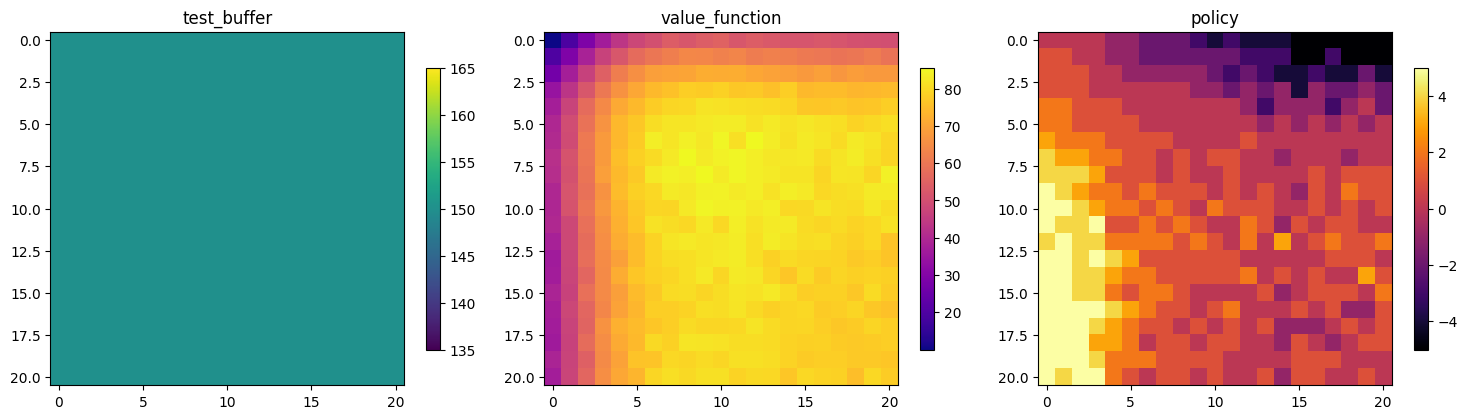

Policy Eval Delta: 4.89236, Max Value: 87.42:  49%|████▉     | 4.892358299558509/10 [01:47<01:52, 21.94s/it]
Policy Improvement: 100%|██████████| 441/441 [09:57<00:00,  1.36s/it]


Total States Changed: 233


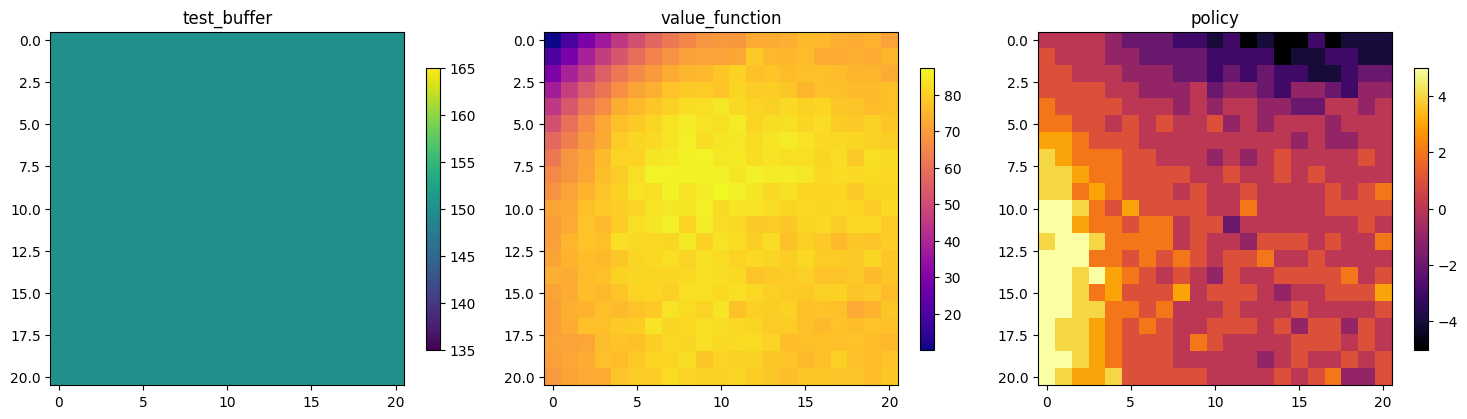

Policy Eval Delta:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [7]:
final_policy = policy_iteration()
print(final_policy)

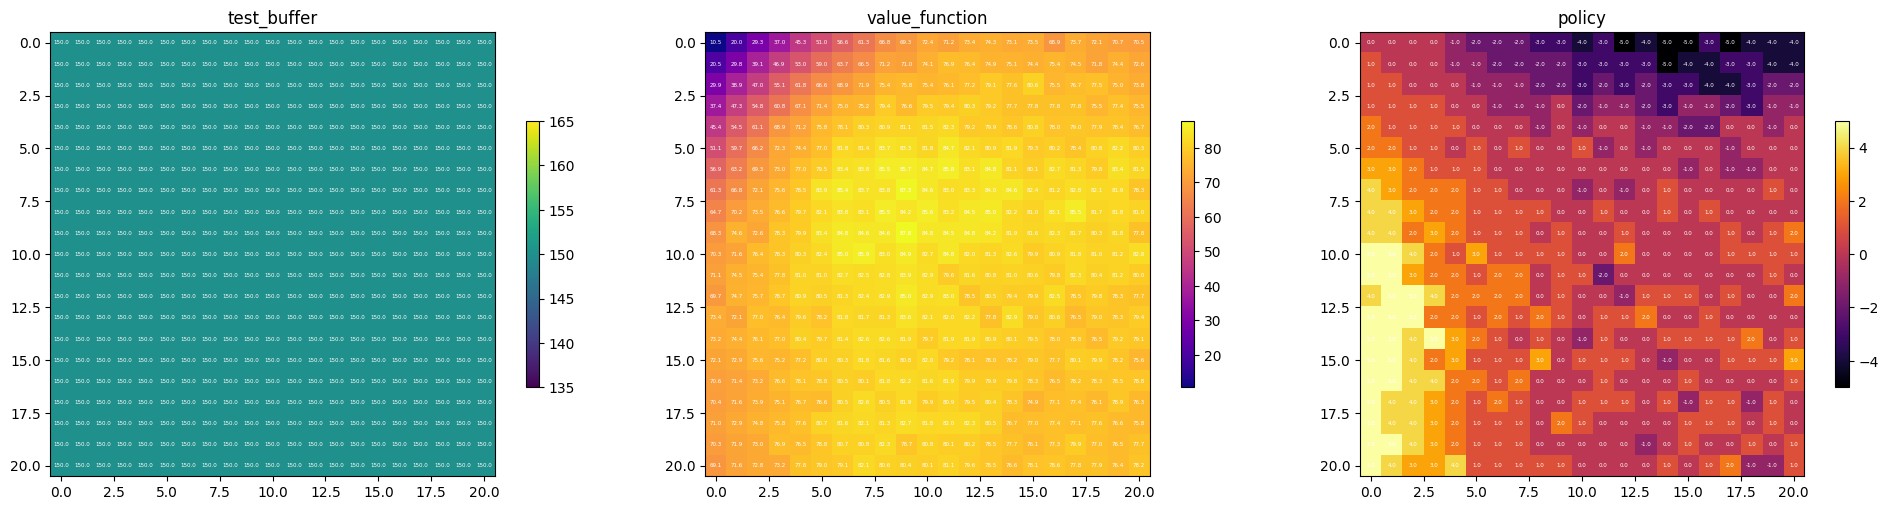

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # Adjust the number of subplots and figure size

def display_values(ax, data, cmap):
    """Utility function to display matrix values."""
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text_val = f"{data[i, j]:.1f}"  # Format to two decimal places
            ax.text(j, i, text_val, ha='center', va='center', color='w', fontsize=4)  # 'w' means white color and fontsize set to 6

# Plotting test_buffer with the 'viridis' colormap and adding a colorbar
im0 = axes[0].imshow(test_buffer, cmap='viridis')
axes[0].set_title("test_buffer")
fig.colorbar(im0, ax=axes[0], shrink=0.6)
display_values(axes[0], test_buffer, 'viridis')

# Plotting value_function with the 'plasma' colormap and adding a colorbar
im1 = axes[1].imshow(value_function, cmap='plasma')
axes[1].set_title("value_function")
fig.colorbar(im1, ax=axes[1], shrink=0.6)
display_values(axes[1], value_function, 'plasma')

# Plotting policy with the 'inferno' colormap and adding a colorbar
im2 = axes[2].imshow(policy, cmap='inferno')
axes[2].set_title("policy")
fig.colorbar(im2, ax=axes[2], shrink=0.6)
display_values(axes[2], policy, 'inferno')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#run the policy on an example

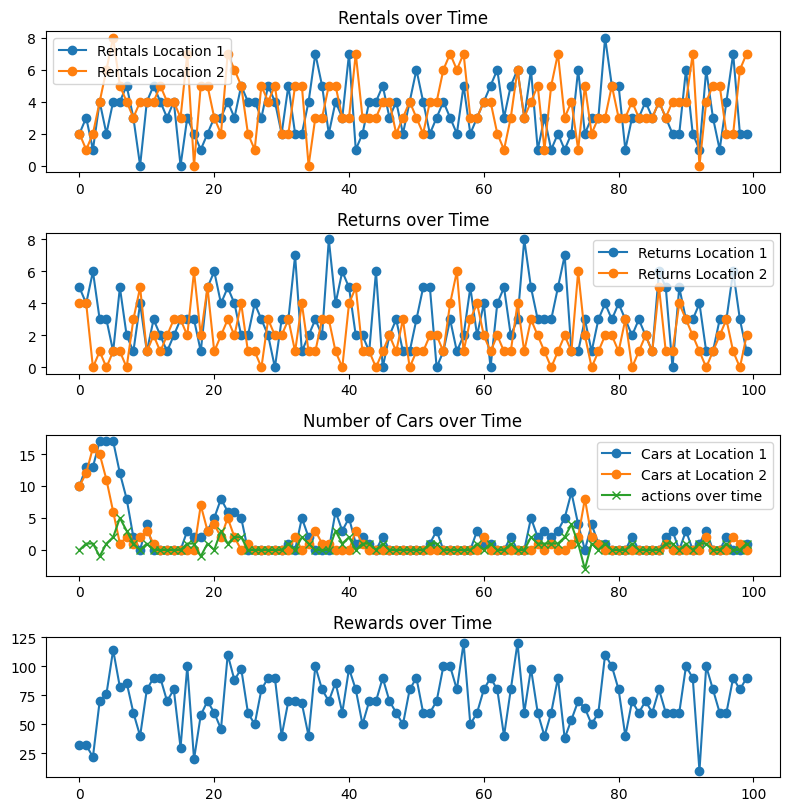

Final state after 100 steps: (0, 0)


In [9]:
import matplotlib.pyplot as plt

def generate_trajectory(initial_state, policy, steps=10, plotting=True):
    states = []
    rewards = []
    rents_loc1_list = []
    rents_loc2_list = []
    returns_loc1_list = []
    returns_loc2_list = []
    actions_list = []

    state = initial_state
    for step in range(steps):
        # Collect states
        states.append(state)

        # Action based on policy
        action = policy[state[0]][state[1]]
        actions_list.append(action)

        # Rentals and returns
        rents_loc1 = poisson.rvs(LAMBDA_REQUEST_1)
        rents_loc2 = poisson.rvs(LAMBDA_REQUEST_2)
        returns_loc1 = poisson.rvs(LAMBDA_RETURN_1)
        returns_loc2 = poisson.rvs(LAMBDA_RETURN_2)

        # Collect data for plotting
        rents_loc1_list.append(rents_loc1)
        rents_loc2_list.append(rents_loc2)
        returns_loc1_list.append(returns_loc1)
        returns_loc2_list.append(returns_loc2)

        # Movement cost
        if action > 0:
            move_cost = MOVE_COST * (action - 1)  # Subtracting 1 car that is moved for free
        else:
            move_cost = MOVE_COST * abs(action)
        reward = RENT_REWARD * (rents_loc1 + rents_loc2) - move_cost

        # Deduct extra parking cost if needed
        if state[0] - rents_loc1 + returns_loc1 - action > 10:
            reward -= EXTRA_PARK_COST
        if state[1] - rents_loc2 + returns_loc2 + action > 10:
            reward -= EXTRA_PARK_COST

        rewards.append(reward)

        # Update state based on dynamics
        cars_loc1 = min(MAX_CARS, max(0, state[0] - rents_loc1 + returns_loc1 - action))
        cars_loc2 = min(MAX_CARS, max(0, state[1] - rents_loc2 + returns_loc2 + action))
        state = (cars_loc1, cars_loc2)

    if not plotting:
        return states, rewards

    # Plot data
    plt.figure(figsize=(8, 10))

    plt.subplot(5, 1, 1)
    plt.plot(range(steps), rents_loc1_list, '-o', label="Rentals Location 1")
    plt.plot(range(steps), rents_loc2_list, '-o', label="Rentals Location 2")
    plt.legend()
    plt.title('Rentals over Time')

    plt.subplot(5, 1, 2)
    plt.plot(range(steps), returns_loc1_list, '-o', label="Returns Location 1")
    plt.plot(range(steps), returns_loc2_list, '-o', label="Returns Location 2")
    plt.legend()
    plt.title('Returns over Time')

    plt.subplot(5, 1, 3)
    plt.plot(range(steps), [s[0] for s in states], '-o', label="Cars at Location 1")
    plt.plot(range(steps), [s[1] for s in states], '-o', label="Cars at Location 2")
    plt.plot(range(steps), actions_list, '-x', label="actions over time")
    plt.legend()
    plt.title('Number of Cars over Time')

    plt.subplot(5, 1, 4)
    plt.plot(range(steps), rewards, '-o')
    plt.title('Rewards over Time')

    plt.tight_layout()
    plt.show()

    return state

# Example (Ensure you've defined and trained the policy variable earlier in the code)
final_state = generate_trajectory((10, 10), policy, steps=100)
print(f"Final state after 100 steps: {final_state}")


better than naive ?

In [14]:
def run_simulation(policy, num_runs=100, steps_per_run=100):
    total_rewards = []

    for _ in tqdm(range(num_runs), desc="Simulation Progress"):
        _, rewards = generate_trajectory((10, 10), policy, steps=steps_per_run, plotting=False)
        total_rewards.append(np.cumsum(rewards))

    average_rewards = np.mean(total_rewards, axis=0)
    return average_rewards

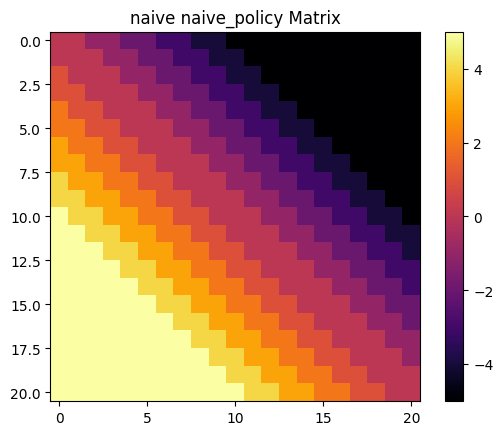

In [15]:
naive_policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

# Introduce a scaling factor for gradual augmentation
scaling_factor = 0.5

for i in range(MAX_CARS + 1):
    for j in range(MAX_CARS + 1):
        diff = i - j

        # Apply the scaling factor
        action = diff * scaling_factor

        # Clip the action to the range [-5, 5]
        naive_policy[i, j] = int(np.clip(action, -5, 5))

# Plot the naive_policy matrix
plt.imshow(naive_policy, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.title('naive naive_policy Matrix')
plt.show()

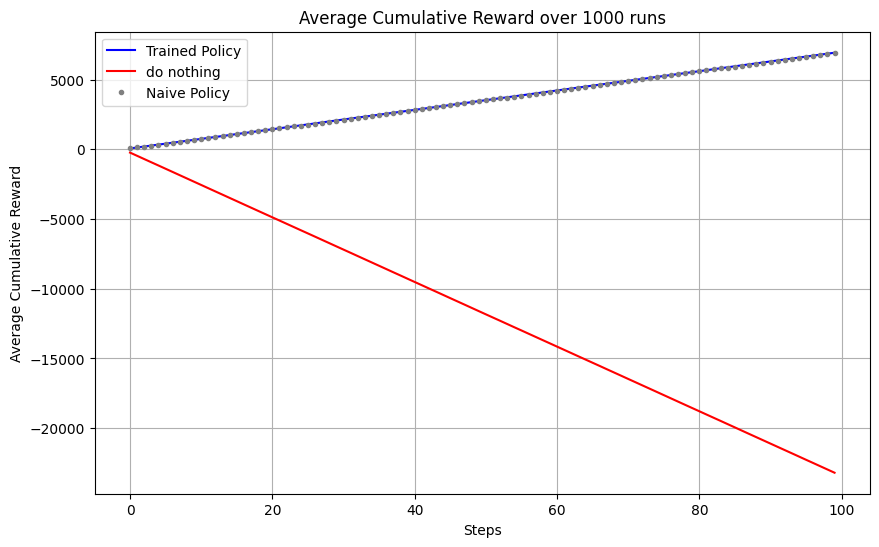

In [28]:
# Number of runs and steps per run
n = 1000
steps = 100

# Run simulations
"""avg_rewards_trained = run_simulation(policy, n, steps)
avg_rewards_naive = run_simulation(naive_policy, n, steps)
avg_rewards_nothing = run_simulation(test_buffer, n, steps)"""

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_trained, label="Trained Policy", color="blue")
plt.plot(avg_rewards_nothing, label="do nothing", color="red")
plt.plot(avg_rewards_naive, ".",  label="Naive Policy",color="gray")
plt.xlabel("Steps")
plt.ylabel("Average Cumulative Reward")
plt.title(f"Average Cumulative Reward over {n} runs")
plt.legend()
plt.grid(True)
plt.show()

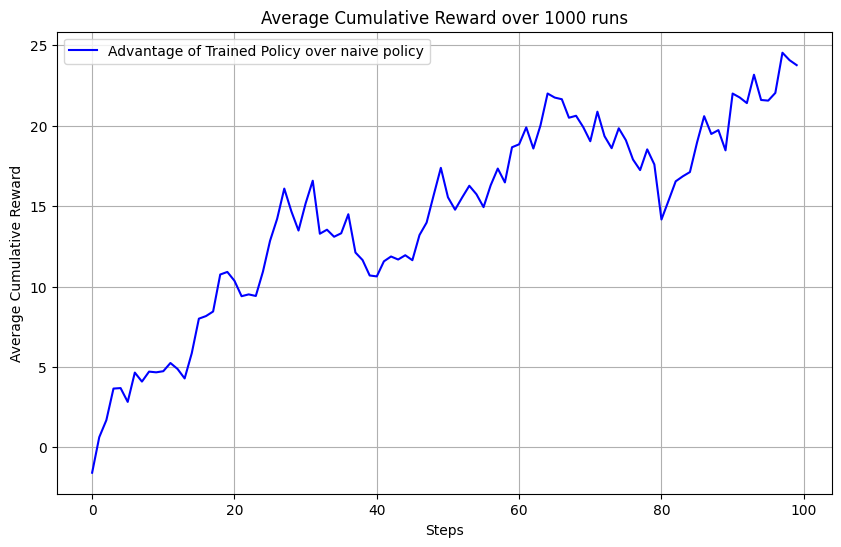

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_trained-avg_rewards_naive, label="Advantage of Trained Policy over naive policy", color="blue")
plt.xlabel("Steps")
plt.ylabel("Average Cumulative Reward")
plt.title(f"Average Cumulative Reward over {n} runs")
plt.legend()
plt.grid(True)
plt.show()